### Import Dataset

In [ ]:
import keras, os
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
train_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range=15, horizontal_flip = True, shear_range = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
path = '/pneumonia_covid19_classification/dataset_balanced'
train_data = train_gen.flow_from_directory(path + '/train', target_size=(224,224),batch_size=64,class_mode='categorical',shuffle=True)
test_data = test_gen.flow_from_directory(path +'/test', target_size=(224,224),batch_size=64,class_mode='categorical',shuffle=True)

Found 1818 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


### Convert Data Label

In [ ]:
from keras.utils.np_utils import to_categorical 
print(train_data.class_indices)
num_classes = len(train_data.class_indices)
train_labels = train_data.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
print(test_data.class_indices)
num_classes = len(test_data.class_indices)
test_labels = test_data.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


### Create VGG16 Model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam

In [ ]:
def create_VGG16():
  vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  #freeze all layers
  for layer in vgg.layers:
    layer.trainable = False
  x = vgg.output
  x = AveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(64,activation='relu')(x)
  final_layer = Dense(3,activation='softmax')(x)
  model = Model(inputs=vgg.input, outputs=final_layer)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model = create_VGG16()

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Callbacks (Tensorboard and ModelCheckpoint)

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint

checkpoint_filepath = '/pneumonia_covid19_classification/VGG16/logs/checkpoint'
log_dir = '/pneumonia_covid19_classification/VGG16/logs'

my_callbacks = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

]


In [ ]:
#initial_epoch = 5
#checkpoint_filepath = '/content/drive/My Drive/FYP/logs/checkpoint'
#from keras.callbacks import ModelCheckpoint
#model_checkpoint_callback = ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=True,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)
#callbacks = [model_checkpoint_callback, tb_callback]

### Train

In [ ]:
initial_epoch = 15

In [ ]:
vgg_model = model.fit(train_data, validation_data=test_data, 
                      epochs=initial_epoch, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      callbacks=my_callbacks)

Epoch 1/15
29/29 [==============================] - 500s 17s/step - loss: 0.5172 - accuracy: 0.8058 - val_loss: 0.2729 - val_accuracy: 0.9125
Epoch 2/15
29/29 [==============================] - 76s 3s/step - loss: 0.2435 - accuracy: 0.9142 - val_loss: 0.2261 - val_accuracy: 0.9229
Epoch 3/15
29/29 [==============================] - 76s 3s/step - loss: 0.1977 - accuracy: 0.9389 - val_loss: 0.2231 - val_accuracy: 0.9271
Epoch 4/15
29/29 [==============================] - 76s 3s/step - loss: 0.1679 - accuracy: 0.9483 - val_loss: 0.1661 - val_accuracy: 0.9458
Epoch 5/15
29/29 [==============================] - 76s 3s/step - loss: 0.1667 - accuracy: 0.9439 - val_loss: 0.1424 - val_accuracy: 0.9521
Epoch 6/15
29/29 [==============================] - 76s 3s/step - loss: 0.1519 - accuracy: 0.9455 - val_loss: 0.1210 - val_accuracy: 0.9542
Epoch 7/15
29/29 [==============================] - 76s 3s/step - loss: 0.1553 - accuracy: 0.9433 - val_loss: 0.1646 - val_accuracy: 0.9417
Epoch 8/15
29/29 [

### Load ModelCheckpoint

In [ ]:
model.load_weights('/pneumonia_covid19_classification/VGG16/logs/checkpoint')

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
num_of_test_samples = 480 
batch_size = 64
test_data.shuffle = False
Y_pred = model.predict_generator(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[159   1   0]
 [  0 159   1]
 [  3  12 145]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.98      0.99      0.99       160
      NORMAL       0.92      0.99      0.96       160
   PNEUMONIA       0.99      0.91      0.95       160

    accuracy                           0.96       480
   macro avg       0.97      0.96      0.96       480
weighted avg       0.97      0.96      0.96       480

Accuracy: 0.9645833333333333


### Fine Tuning

In [ ]:
#unfreeze all layers
model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  23


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Let's take a look at the base model architecture
model.summary()
len(model.trainable_variables)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

8

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epoch + fine_tune_epochs
print(total_epochs)
print(vgg_model.epoch)

30
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Callbacks - Finetune

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint
# %load_ext tensorboard

checkpoint_filepath = '/pneumonia_covid19_classification/VGG16/logs/checkpoint_finetune'
log_dir = '/pneumonia_covid19_classification/VGG16/logs'

my_fine_callbacks = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

]

In [ ]:
vgg_model_fine = model.fit(train_data, validation_data=test_data, 
                      epochs=total_epochs, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      initial_epoch=vgg_model.epoch[-1] + 1,
                      callbacks=my_fine_callbacks)

Epoch 16/30
29/29 [==============================] - 78s 3s/step - loss: 0.4953 - accuracy: 0.8443 - val_loss: 0.1411 - val_accuracy: 0.9479
Epoch 17/30
29/29 [==============================] - 75s 3s/step - loss: 0.1587 - accuracy: 0.9472 - val_loss: 0.0970 - val_accuracy: 0.9625
Epoch 18/30
29/29 [==============================] - 76s 3s/step - loss: 0.1462 - accuracy: 0.9538 - val_loss: 0.1831 - val_accuracy: 0.9396
Epoch 19/30
29/29 [==============================] - 76s 3s/step - loss: 0.1304 - accuracy: 0.9587 - val_loss: 0.0930 - val_accuracy: 0.9667
Epoch 20/30
29/29 [==============================] - 77s 3s/step - loss: 0.1091 - accuracy: 0.9604 - val_loss: 0.1141 - val_accuracy: 0.9625
Epoch 21/30
29/29 [==============================] - 77s 3s/step - loss: 0.1058 - accuracy: 0.9615 - val_loss: 0.0851 - val_accuracy: 0.9667
Epoch 22/30
29/29 [==============================] - 77s 3s/step - loss: 0.0767 - accuracy: 0.9763 - val_loss: 0.0901 - val_accuracy: 0.9708
Epoch 23/30
2

In [ ]:
model.load_weights('/pneumonia_covid19_classification/VGG16/logs/checkpoint_finetune')

### Confusion Matrix (FineTune)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
num_of_test_samples = 480 
batch_size = 64
test_data.shuffle = False
Y_pred = model.predict(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[160   0   0]
 [  0 158   2]
 [  3   8 149]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.98      1.00      0.99       160
      NORMAL       0.95      0.99      0.97       160
   PNEUMONIA       0.99      0.93      0.96       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480

Accuracy: 0.9729166666666667


### Visualization

In [1]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


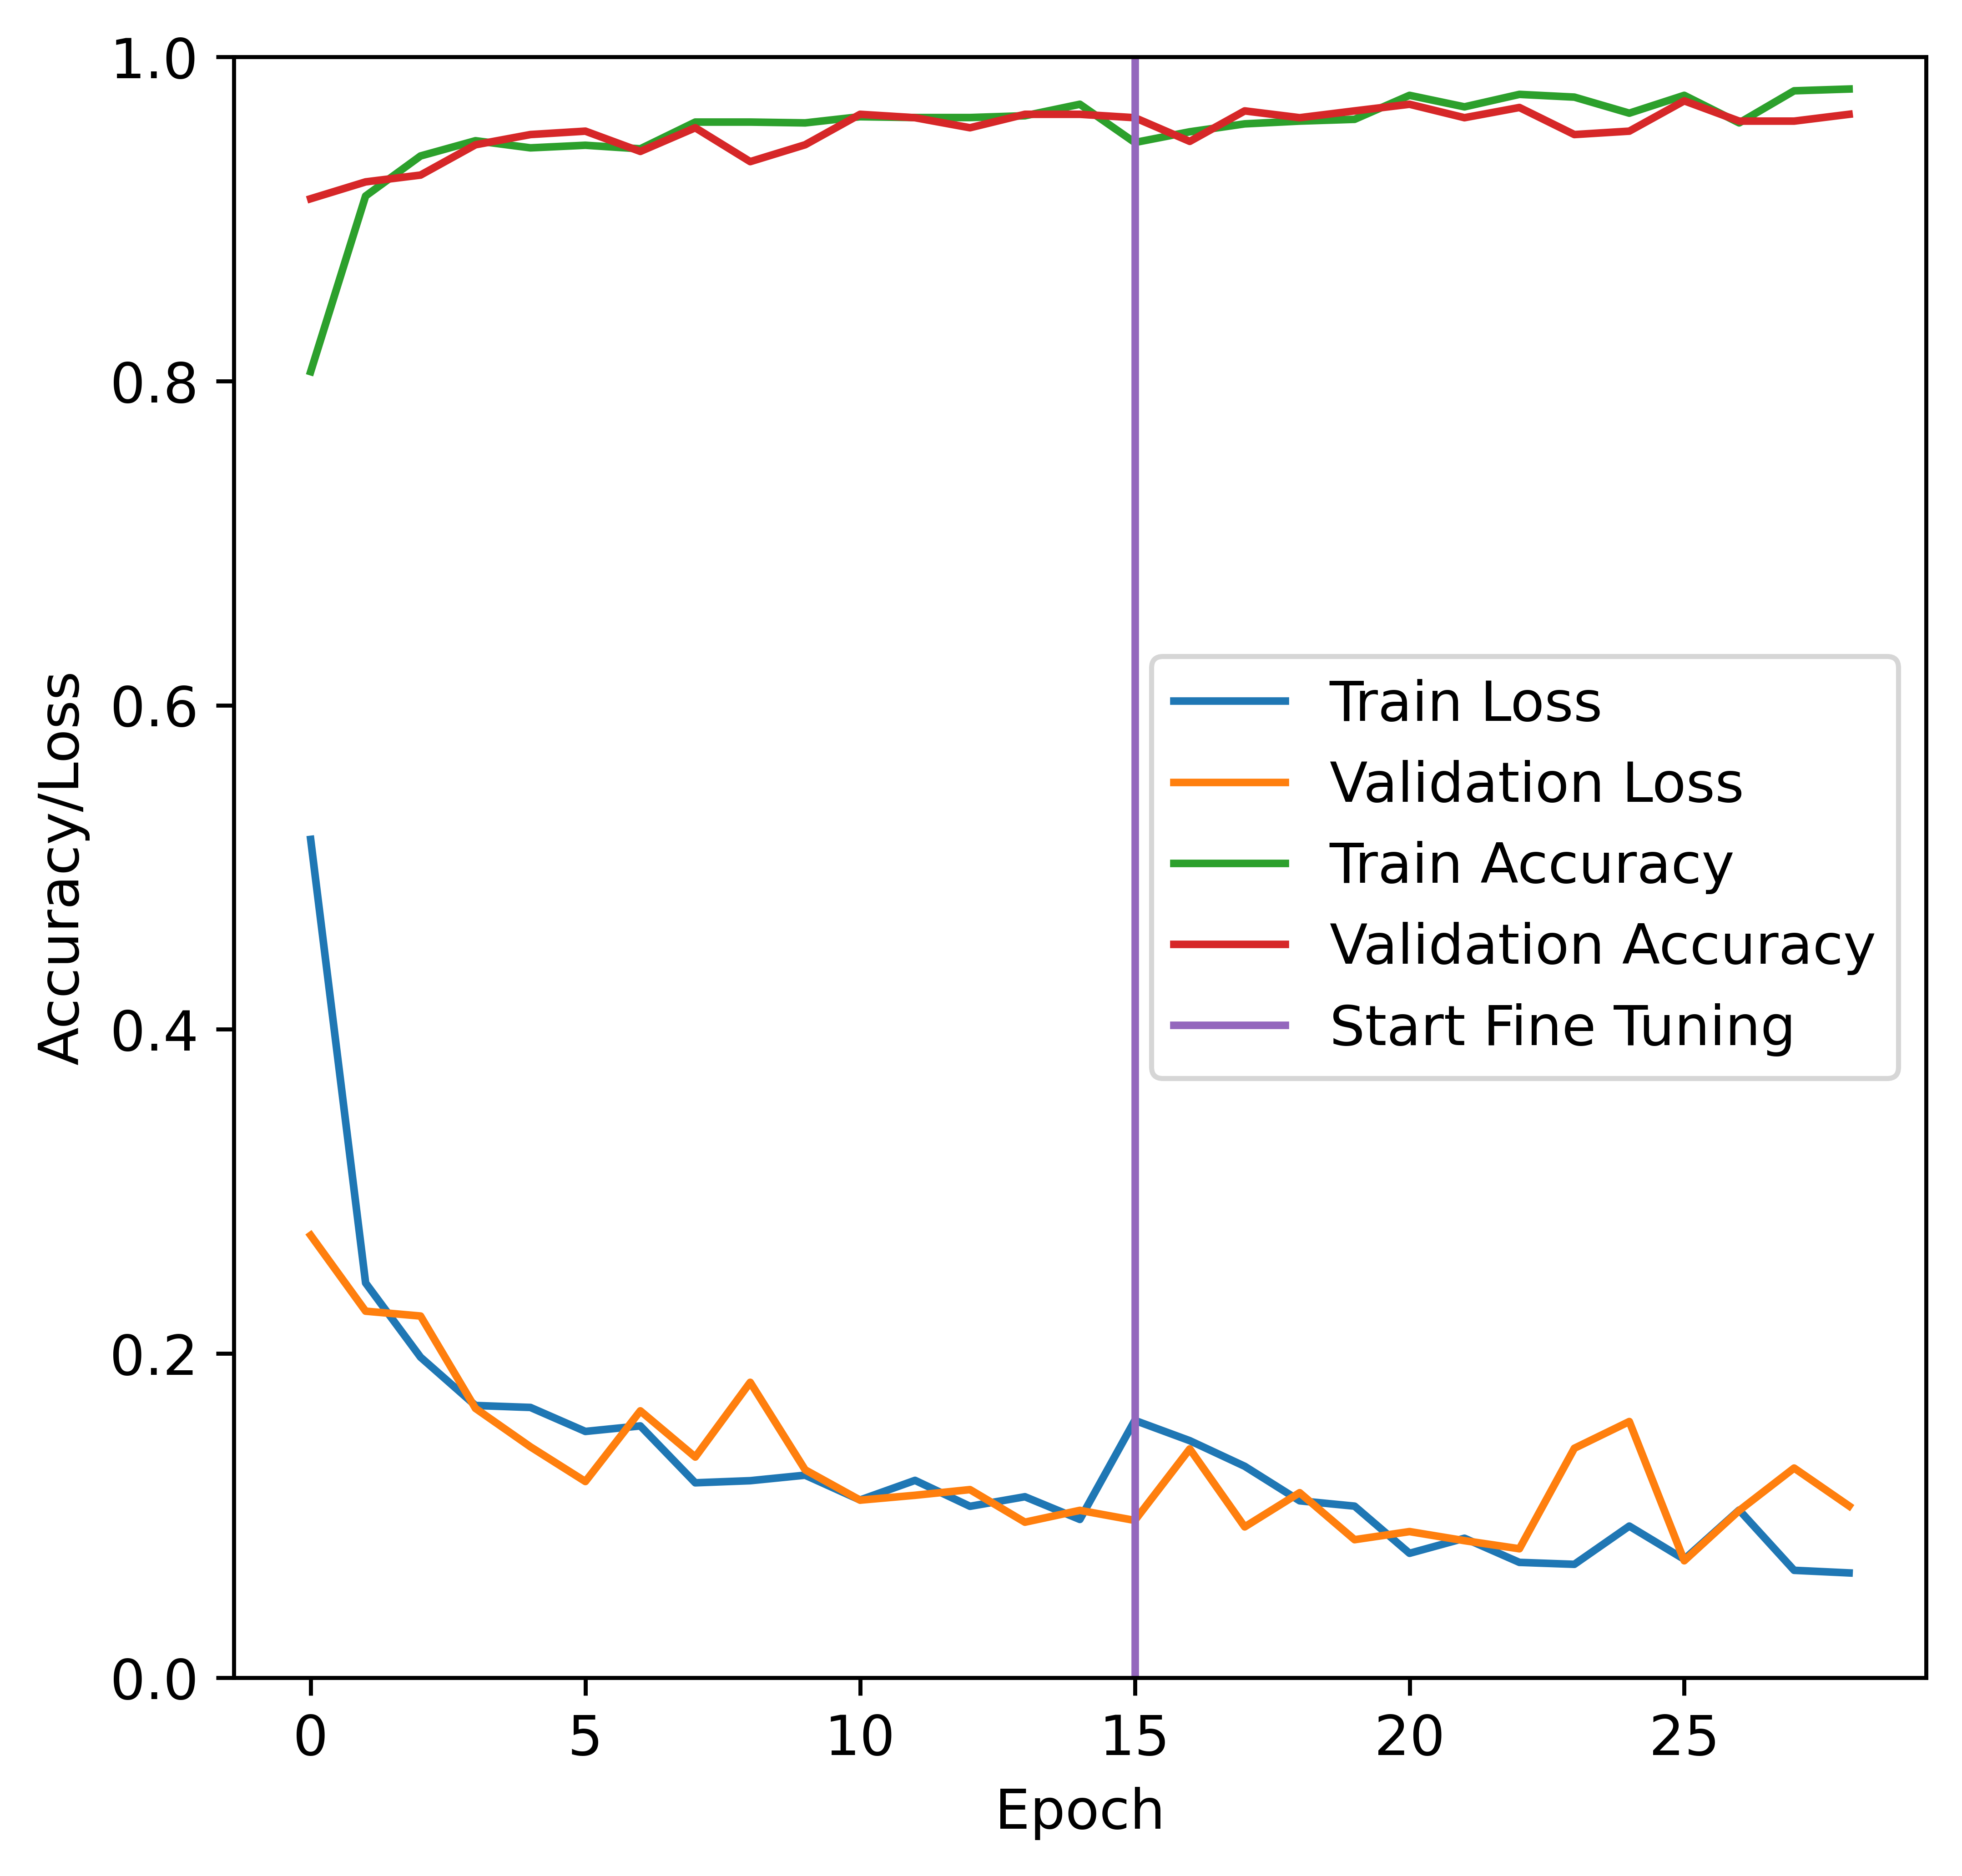

In [3]:
plt.figure(figsize=(6,5.9), dpi=800)
plt.rcParams.update({'font.size': 11})
plt.plot(loss3, label = 'Train Loss')
plt.plot(val_loss3, label = 'Validation Loss')
plt.plot(acc3, label = 'Train Accuracy')
plt.plot(val_acc3, label = 'Validation Accuracy')
plt.ylim([0, 1.0])
initial_epoch = 15
plt.plot([initial_epoch,initial_epoch],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='middle right')
# plt.title('Model Loss and Accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()